In [ ]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.signal import gaussian
from scipy.stats import kurtosis

In [ ]:
signal1 = np.random.rand(100) # non - gaussian uniform
x = np.linspace(-5, 5, 100)
mu = 0
sigma = 1
signal2 = gaussian(len(x),sigma) # gaussian
sigma = 3
#signal3 = gaussian(len(x),sigma)
signal3 = np.random.normal(size=100) # gaussian

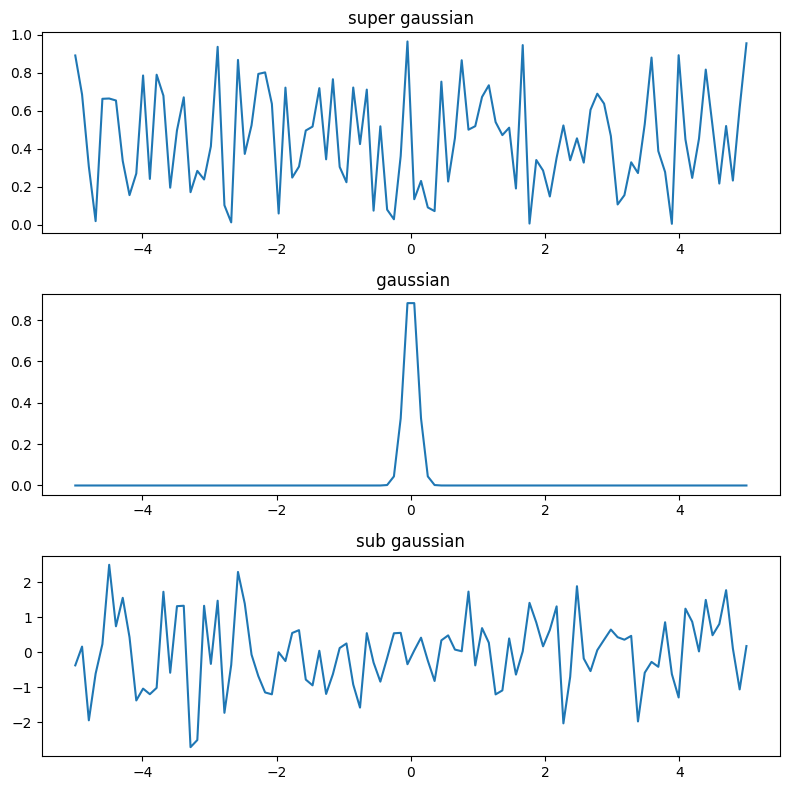

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].plot(x, signal1)
axs[0].set_title('super gaussian')
axs[1].plot(x, signal2)
axs[1].set_title(' gaussian')
axs[2].plot(x, signal3)
axs[2].set_title('sub gaussian')
plt.tight_layout()
plt.show()

###kurtosis

In [ ]:
signal1_kurtosis = kurtosis(signal1)
print(signal1_kurtosis)
signal2_kurtosis = kurtosis(signal2)
print(signal2_kurtosis)
signal3_kurtosis = kurtosis(signal3)
print(signal3_kurtosis)

-0.9968272110414671
34.54554392711402
-0.07998856500740503


### Mixed data by using mixing matrix

In [ ]:
S = np.array([signal1, signal2, signal3]).T #  creating Source Matrix
print ('S',S.shape)
A = np.array([[0.5, 1, 0.2], [1, 0.5, 0.4], [0.5, 0.8, 1]]) # Mixing matrix
X = S.dot(A).T # Mixed signal matrix
#print (X)

S (100, 3)


In [ ]:
S.shape
print (X[:,0])

[ 0.26154665  0.59686764 -0.19047872]


In [ ]:

X.shape

(3, 100)

### plot mixed signals

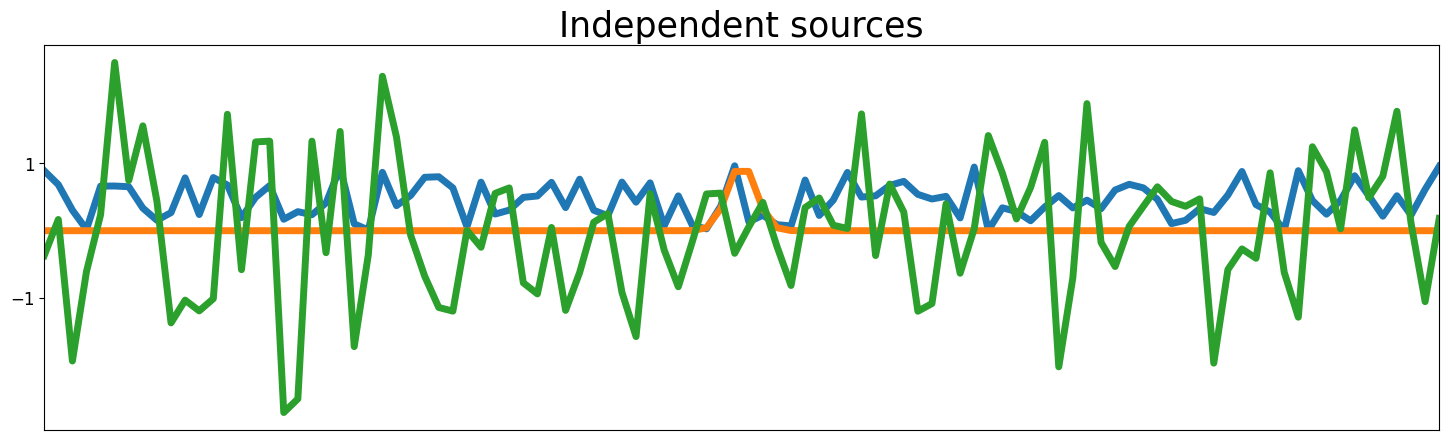

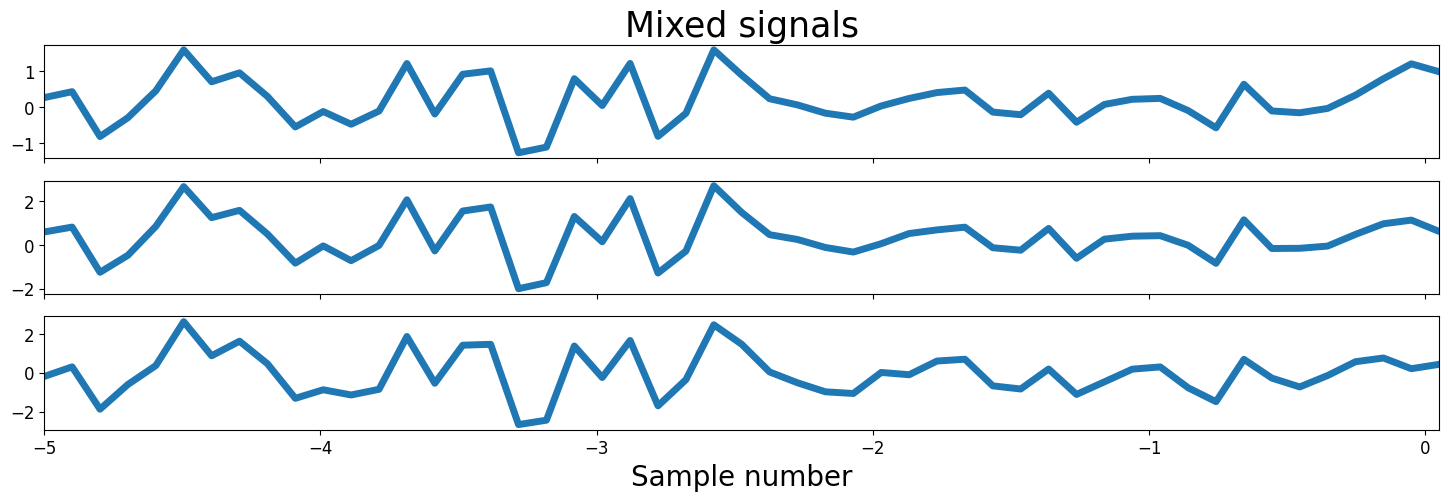

(3, 100)


In [ ]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(x, S, lw=5)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(x[0], x[-1])
ax.tick_params(labelsize=12)
ax.set_title('Independent sources', fontsize=25)

fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(x, X[0], lw=5)
ax[0].set_title('Mixed signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(x, X[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(x[0], x[-1])

ax[2].plot(x, X[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(x[0], x[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(x[0], x[50])

plt.show()
print(X.shape)

### Preprocesing steps

In [ ]:
def center(x):
 mean = np.mean(x,keepdims=True)
 centered =  x - mean
 return centered, mean
def covariance(x):
  mean = np.mean(x, keepdims=True)
  n = np.shape(x)[0] - 1
  m = x - mean
  return (m.dot(m.T))/n

In [ ]:
Xc, meanX = center(X)
Xc.shape

(3, 100)

In [ ]:
def whiten(X):
  coVarM = np.cov(X) # Calculate the covariance matrix
  U, S, V = np.linalg.svd(coVarM)  # singular value decoposition
  d = np.diag(1.0 / np.sqrt(S))  # Calculate diagonal matrix of eigenvalues
  whiteM = np.dot(U, np.dot(d, V)) # Calculate whitening matrix
  Xw = np.dot(whiteM, X)     # Whitened data
  return Xw, whiteM

In [ ]:
Xw, whiteM = whiten(Xc)
Xw.shape

(3, 100)

### CICA

In [ ]:
# calculate the kurtosis for each signal
nsignals = 100

U = [signal1_kurtosis, signal2_kurtosis, signal3_kurtosis]

I = []
I_ = []
for i in range(len(U)):
  I.append(U[i]*U[i])
  I_.append(2*U[i])

def sigmoid(x):
  return 1/(1+np.exp(-x))

W0 = np.random.random((3, 3))
W = np.copy(W0)
mu = np.zeros(2)
si = np.zeros(3)
nW = np.stack(W for i in range(nsignals))

iterations = 100
gamma = 0.1
for k in range(0,iterations):
  for i in range(len(mu)):
    mu[i] = max(0,mu[i] + gamma*(I[i+1]-I[i]))
  si[0] = sigmoid(U[0]) - mu[0]*I_[0]
  si[1] = sigmoid(U[1]) - (mu[0]-mu[1])*I_[1]
  si[2] = sigmoid(U[2]) + mu[1]*I_[2]
  # for i in range(1,2):
  #   si[i] = sigmoid(U[i]) - (mu[i-1]-mu[i])*I_[i]
  for j in range(nsignals):
    #print (si)
    xj = X[:,j]
    #print ('xj',xj)
    xjreshape = np.reshape(xj,(1,len(xj)))
    #print ('reshaped xj',xjreshape.shape)
    sij = np.reshape(si,(len(xj),1))
    #print ('sij',sij.shape)
    #print ('reshaped sij',sij.shape)
    # print (np.matmul(sij,xjreshape))
    Winverse = (np.linalg.inv(nW[j])).T
    dW =np.add(Winverse, np.matmul(sij,xjreshape))
    nW[j] = np.subtract(nW[j],dW)
  #print(nW)


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
U

[-0.9968272110414671, 34.54554392711402, -0.07998856500740503]

### Recoverd signals

In [ ]:
rec_sig = []

# print (rec_sig)
for i in range(nsignals):
  # print (Xw[:,i].shape)
  # print (Xw[:,i].reshape(3,1))
  # print (nW[i])
  a = Xw[:,i].reshape(3,1)
  rec_sig.append(np.matmul(nW[i],a))
  # print ('rec_sig[i]',rec_sig)

#print (rec_sig)

In [ ]:
rec_sig=np.reshape(rec_sig,(3,100))

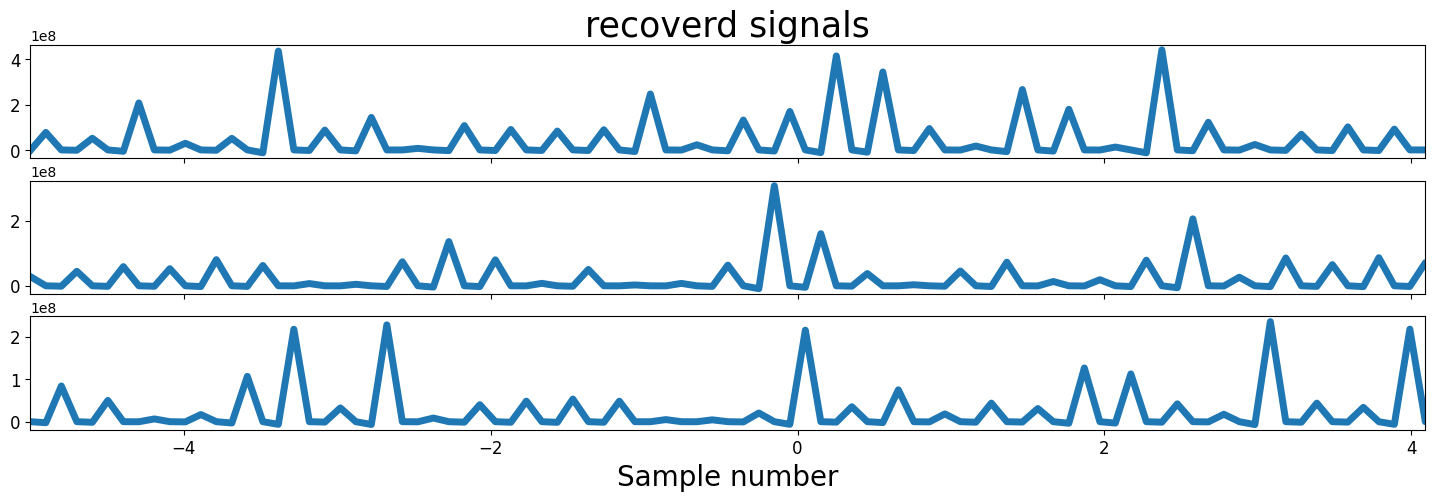

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(x, rec_sig[0], lw=5)
ax[0].set_title('recoverd signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(x, rec_sig[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(x[0], x[-1])

ax[2].plot(x, rec_sig[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(x[0], x[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(x[0], x[90])

plt.show()
#print(X.shape)

In [ ]:
rec_sig1_kurtosis = kurtosis(rec_sig[0])
print(rec_sig1_kurtosis)
rec_sig2_kurtosis = kurtosis(rec_sig[1])
print(rec_sig2_kurtosis)
rec_sig3_kurtosis = kurtosis(rec_sig[2])
print(rec_sig3_kurtosis)

7.743831098721991
13.892161793381124
7.09813336986865


###Experiment 2

In [ ]:
S = np.array([signal1, signal2, signal3]).T #  creating Source Matrix
print ('S',S.shape)
A1 = np.array([[3, 3.3, 0.2], [2.9, 1.5, 1.4], [3.5, 1.8, 2.6]])
#A = np.array([[0.5, 1, 0.2], [1, 0.5, 0.4], [0.5, 0.8, 1]]) # Mixing matrix
X1 = S.dot(A1).T # Mixed signal matrix
#print (X1)

S (100, 3)


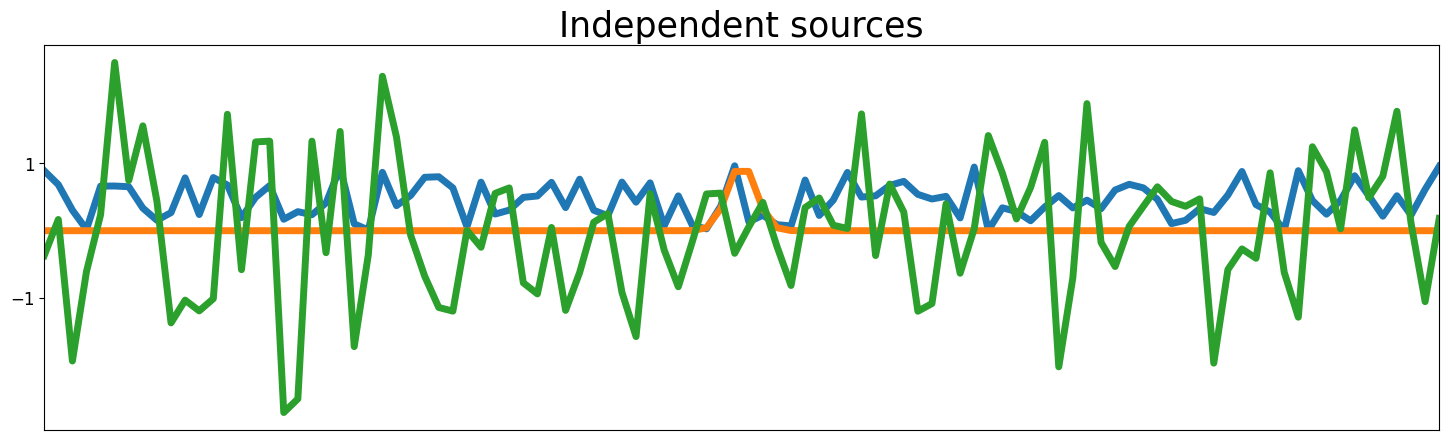

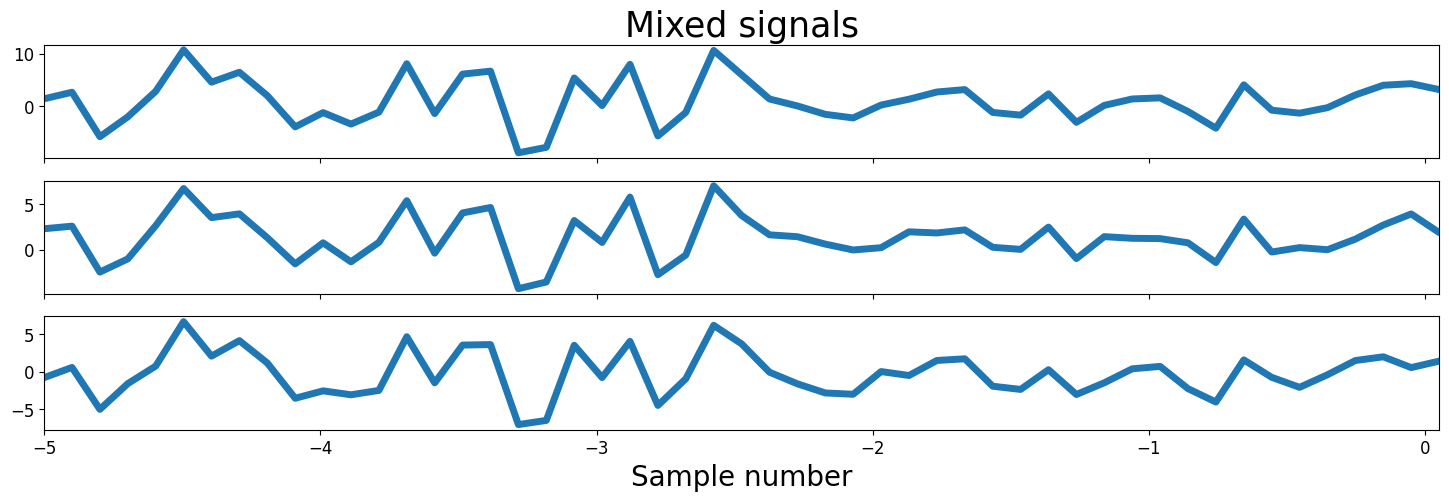

(3, 100)


In [ ]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(x, S, lw=5)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(x[0], x[-1])
ax.tick_params(labelsize=12)
ax.set_title('Independent sources', fontsize=25)

fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(x, X1[0], lw=5)
ax[0].set_title('Mixed signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(x, X1[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(x[0], x[-1])

ax[2].plot(x, X1[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(x[0], x[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(x[0], x[50])

plt.show()
print(X1.shape)

In [ ]:
def center(x):
 mean = np.mean(x,keepdims=True)
 centered =  x - mean
 return centered, mean
def covariance(x):
  mean = np.mean(x, keepdims=True)
  n = np.shape(x)[0] - 1
  m = x - mean
  return (m.dot(m.T))/n

In [ ]:
X1c, meanX1 = center(X1)
X1c.shape

(3, 100)

In [ ]:
def whiten(X1):
  coVarM1 = np.cov(X1) # Calculate the covariance matrix
  U, S, V = np.linalg.svd(coVarM1)  # singular value decoposition
  d = np.diag(1.0 / np.sqrt(S))  # Calculate diagonal matrix of eigenvalues
  whiteM1 = np.dot(U, np.dot(d, V)) # Calculate whitening matrix
  X1w = np.dot(whiteM, X1)     # Whitened data
  return X1w, whiteM1

In [ ]:
X1w, whiteM1 = whiten(X1c)
X1w.shape

(3, 100)

In [ ]:
def fastIca(signals,  alpha = 1, thresh=1e-8, iterations=5000):
  m, n = signals.shape
  W = np.random.rand(m, m) # Now we will initialize random weights
  for c in range(m):
    w = W[c, :].copy().reshape(m, 1)
    w = w / np.sqrt((w ** 2).sum())

    i = 0
    lim = 100
    while ((lim > thresh) & (i < iterations)):
      ws = np.dot(w.T, signals) # The dot product of weights and signals
      wg = np.tanh(ws * alpha).T # ws is passed into contrast function g
      wg_ = (1 - np.square(np.tanh(ws))) * alpha # ws is passed g prime
      wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze() # here we are updating the weights
      wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c]) # Weights are decorrelated
      wNew = wNew / np.sqrt((wNew ** 2).sum())
      lim = np.abs(np.abs((wNew * w).sum()) - 1) # Limit condition is calculated
      w = wNew # Weights are updated
      i += 1

      W[c, :] = w.T
      return W

In [ ]:
# calculate the kurtosis for each signal
nsignals = 100

kurt1 = kurtosis(signal1)
np.append(U,kurt1)
kurt2 = kurtosis(signal2)
np.append(U,kurt2)
kurt3 = kurtosis(signal3)
np.append(U,kurt3)

U = np.array(U)
U = [signal1_kurtosis, signal2_kurtosis, signal3_kurtosis]

I1 = []
I1_ = []
for i in range(len(U)):
  I1.append(U[i]*U[i])
  I1_.append(2*U[i])

def sigmoid(x):
  return 1/(1+np.exp(-x))

W10 = np.random.random((3, 3))
W1 = np.copy(W10)
mu1 = np.zeros(2)
si1 = np.zeros(3)
#nW1 = np.stack(W1 for i in range(nsignals))
nW1 = []
for i in range(nsignals):
  w_ = np.random.random((3, 3))
  nW1.append(w_)


iterations = 100
gamma = 0.1
for k in range(0,iterations):
  for i in range(len(mu1)):
    mu1[i] = max(0,mu1[i] + gamma*(I1[i+1]-I1[i]))
  si1[0] = sigmoid(U[0]) - mu1[0]*I1_[0]
  si1[1] = sigmoid(U[1]) - (mu1[0]-mu1[1])*I1_[1]
  si1[2] = sigmoid(U[2]) + mu[1]*I1_[2]
  # for i in range(1,2):
  #   si[i] = sigmoid(U[i]) - (mu[i-1]-mu[i])*I_[i]
  for j in range(nsignals):
    #print (si)
    xj1 = X1[:,j]
    #print ('xj',xj)
    xj1reshape = np.reshape(xj1,(1,len(xj1)))
    #print ('reshaped xj',xjreshape.shape)
    sij1 = np.reshape(si1,(len(xj1),1))
    #print ('sij',sij.shape)
    #print ('reshaped sij',sij.shape)
    # print (np.matmul(sij,xjreshape))
    W1inverse = (np.linalg.inv(nW1[j])).T
    dW1 =np.add(W1inverse, np.matmul(sij1,xjreshape))
    nW1[j] = np.subtract(nW1[j],dW1)
  #print(nW1)


In [ ]:
rec_sigs = []

# print (rec_sig1)
for i in range(nsignals):
  # print (Xw[:,i].shape)
  # print (Xw[:,i].reshape(3,1))
  # print (nW[i])
  a = X1w[:,i].reshape(3,1)
  rec_sigs.append(np.matmul(nW1[i],a))
  # print ('rec_sig[i]',rec_sig)

#print (rec_sigs)

In [ ]:
rec_sigs=np.reshape(rec_sigs,(3,100))

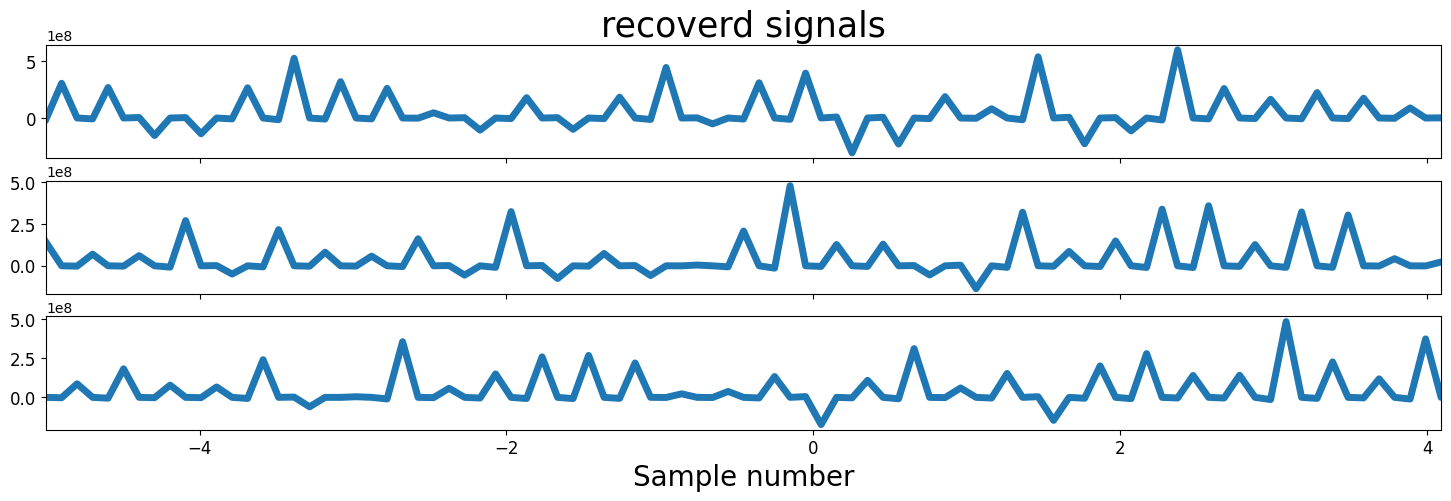

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(x, rec_sigs[0], lw=5)
ax[0].set_title('recoverd signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(x, rec_sigs[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(x[0], x[-1])

ax[2].plot(x, rec_sigs[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(x[0], x[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(x[0], x[90])

plt.show()
#print(X1.shape)

In [ ]:
rec_sigs1_kurtosis = kurtosis(rec_sigs[0])
print(rec_sigs1_kurtosis)
rec_sigs2_kurtosis = kurtosis(rec_sigs[1])
print(rec_sigs2_kurtosis)
rec_sigs3_kurtosis = kurtosis(rec_sigs[2])
print(rec_sigs3_kurtosis)

3.232520782758341
3.37903330744365
3.442957679295197


In [ ]:
nW1[0]

array([[-6.83369635e+05, -1.32270404e+06, -4.48203797e+05],
       [ 2.36777790e+07,  4.58409264e+07,  1.55296780e+07],
       [ 1.75178045e+02, -1.81934952e+02,  5.59993139e+01]])

In [ ]:
nW1[1]

array([[-6.83246679e+05, -1.32280276e+06, -4.48113331e+05],
       [ 2.36777817e+07,  4.58409214e+07,  1.55296812e+07],
       [-3.97028476e+01, -4.29557648e+01, -1.60631514e+01]])